In [12]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from matplotlib import style
style.use('seaborn')

/tmp/ipykernel_536847/1900012673.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn')


# Data Preparation

In [13]:
df = pd.read_csv('winequalityN.csv')
df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [14]:
df.columns = df.columns.str.lower().str.replace(' ','_')
df.columns

Index(['type', 'fixed_acidity', 'volatile_acidity', 'citric_acid',
       'residual_sugar', 'chlorides', 'free_sulfur_dioxide',
       'total_sulfur_dioxide', 'density', 'ph', 'sulphates', 'alcohol',
       'quality'],
      dtype='object')

## Target 
Lets understand how the target variable is distributed in the dataset.

<AxesSubplot: >

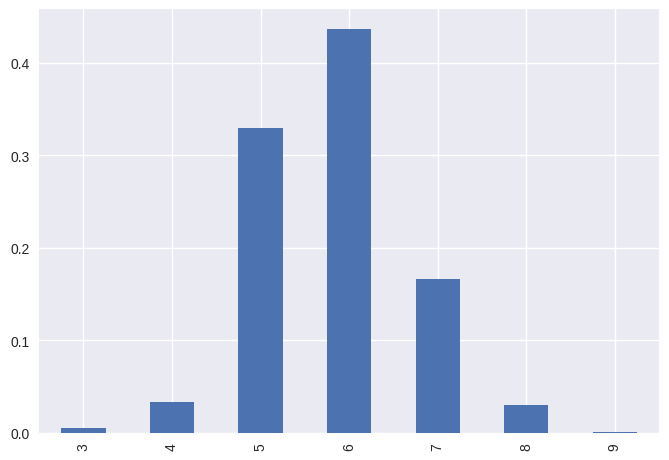

In [15]:
df.quality.value_counts(normalize=True).sort_index().plot.bar()

*Wine Quality* is a score from 0-10. However, in the dataset that we have available, we see that we only have wines with quality from 3-8. One thing we can do, is convert *Quality* into a multilabel classification problem: Bad, moderate and good wine quality depending on a *quality* cutoff. 

Another thing to observe is that dataset is unbalanced. About ~70% of the dataset is in the quality range of 5 and 6. For example, if wines are good if their quality is >= 7, then only about the 20% of the dataset will be consider good wine. This is something to think about when we perform dataset splitting

In [16]:
bad = (df['quality'] <5) 
moderate = (df['quality'] >=5) & (df['quality'] <7)
good = (df['quality'] >=7)

df.loc[bad,'quality'] = 'bad'
df.loc[moderate,'quality'] = 'moderate'
df.loc[good,'quality'] = 'good'


In [17]:
df['quality'].value_counts(normalize=True)

moderate    0.765584
good        0.196552
bad         0.037864
Name: quality, dtype: float64

In [18]:
df.quality.value_counts()

moderate    4974
good        1277
bad          246
Name: quality, dtype: int64

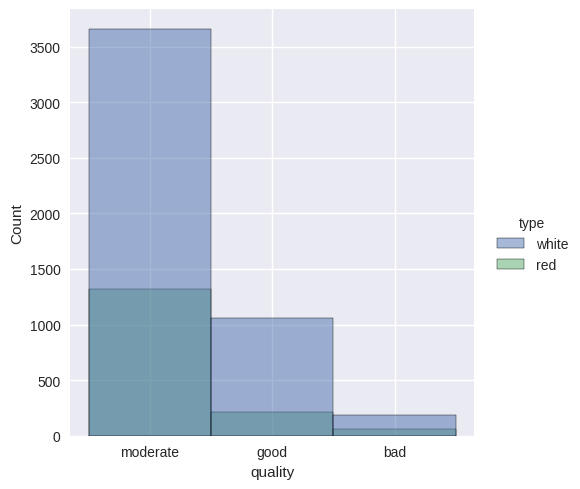

In [19]:
sns.displot(df,x='quality',hue='type')

## Missing values

Lets checkout the features. 
- Do we have missing data?
- Is the correlation between the features high? 

### Missing data

In [20]:
df.isnull().sum()

type                     0
fixed_acidity           10
volatile_acidity         8
citric_acid              3
residual_sugar           2
chlorides                2
free_sulfur_dioxide      0
total_sulfur_dioxide     0
density                  0
ph                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64

Lets use the Mean for each of the missing quantities and fill the missing values with them

In [21]:
cols_with_missing = df.isnull().sum()[(df.isnull().sum() > 0)].index 

df.groupby(by='type')[cols_with_missing].mean()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,ph,sulphates
type,,,,,,,
red,8.322104,0.527738,0.271145,2.538806,0.087467,3.310864,0.658078
white,6.855532,0.278252,0.334250,6.393250,0.045778,3.188203,0.489835


In [22]:
cols_with_missing = df.isnull().sum()[(df.isnull().sum() > 0)].index

missing_dict = {}
for col in cols_with_missing: 
    tmp = {}
    for t in df.type.unique():
        mask = (df.type == t)
        mean = df.loc[mask,col].mean().round(3)
        df.loc[mask,col] = df.loc[mask,col].fillna(mean)
        tmp.update({t:mean})
    missing_dict[col] = tmp 

In [23]:
missing_dict

{'fixed_acidity': {'white': 6.856, 'red': 8.322},
 'volatile_acidity': {'white': 0.278, 'red': 0.528},
 'citric_acid': {'white': 0.334, 'red': 0.271},
 'residual_sugar': {'white': 6.393, 'red': 2.539},
 'chlorides': {'white': 0.046, 'red': 0.087},
 'ph': {'white': 3.188, 'red': 3.311},
 'sulphates': {'white': 0.49, 'red': 0.658}}

## Data types

We can see that all the features are numerical, since they measure distinct chemical and physical properties of the wine.

In [25]:
df.dtypes

type                     object
fixed_acidity           float64
volatile_acidity        float64
citric_acid             float64
residual_sugar          float64
chlorides               float64
free_sulfur_dioxide     float64
total_sulfur_dioxide    float64
density                 float64
ph                      float64
sulphates               float64
alcohol                 float64
quality                  object
dtype: object

# Set up validation framwork 

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
df.type = df['type'].map({'red':0,'white':1})
df.quality= df['quality'].map({'bad':0,'moderate':1,'good':2})

In [28]:
df_full_train,df_test = train_test_split(df,test_size=0.2,stratify=df.quality,random_state=1)
df_train,df_val = train_test_split(df_full_train,test_size=0.25,stratify=df_full_train.quality,random_state=1)

In [29]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.quality.values
y_val = df_val.quality.values
y_test = df_test.quality.values

del df_train['quality']
del df_val['quality']
del df_test['quality']

# EDA

## Features

In [30]:
features = df_full_train.columns.tolist()
features.remove('quality')

<AxesSubplot: >

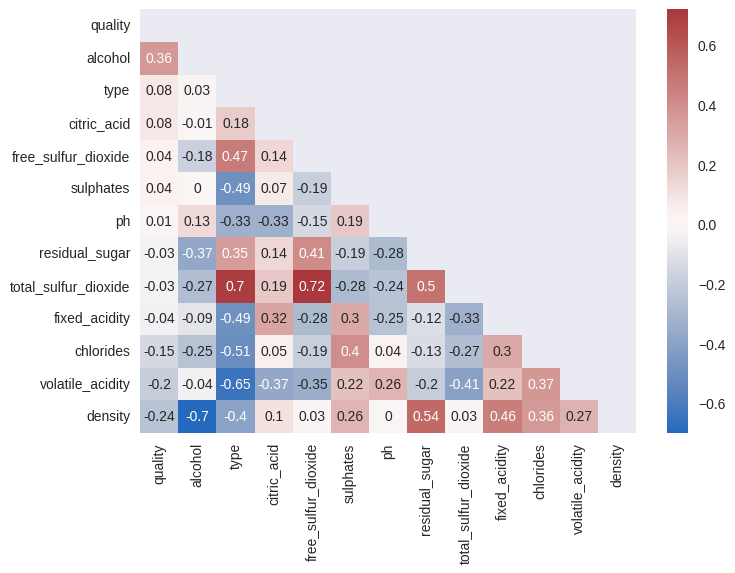

In [31]:
corr = df_full_train[features+['quality']].corr().round(2)
top_corr_cols = corr.quality.sort_values(ascending=False).keys() 
top_corr = corr.loc[top_corr_cols, top_corr_cols] 
mask = np.triu(np.ones_like(top_corr, dtype=bool)) 
sns.heatmap(top_corr,annot=True,cmap='vlag',mask = mask)

We see that some of the features have quite high correlation between them. 

-   free_sulfur_dioxide,total_sulfur_dioxide
-   density, alcohol

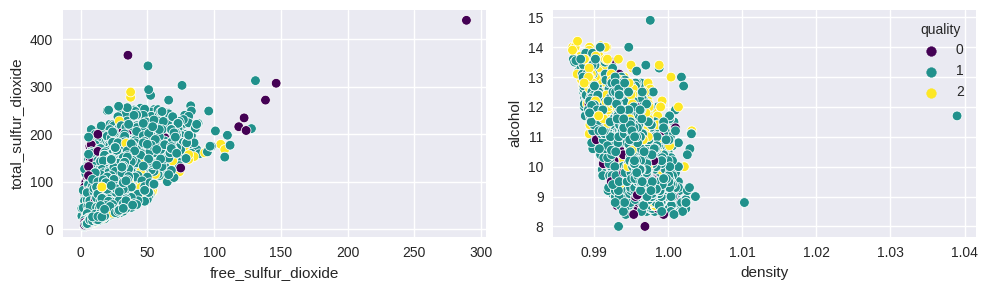

In [32]:
pairs = [
        ('free_sulfur_dioxide','total_sulfur_dioxide'),
        ('density','alcohol'),
        ]

fig,ax =plt.subplots(ncols=len(pairs),figsize=(10,3))
for i,pair in enumerate(pairs):
    x,y =pair 
    sns.scatterplot(x=x,y=y,hue='quality',palette='viridis',data=df,ax=ax[i])
    ax[i].set_aspect('auto')

for i in range(len(pairs)-1):
    ax[i].legend().remove()
fig.tight_layout()

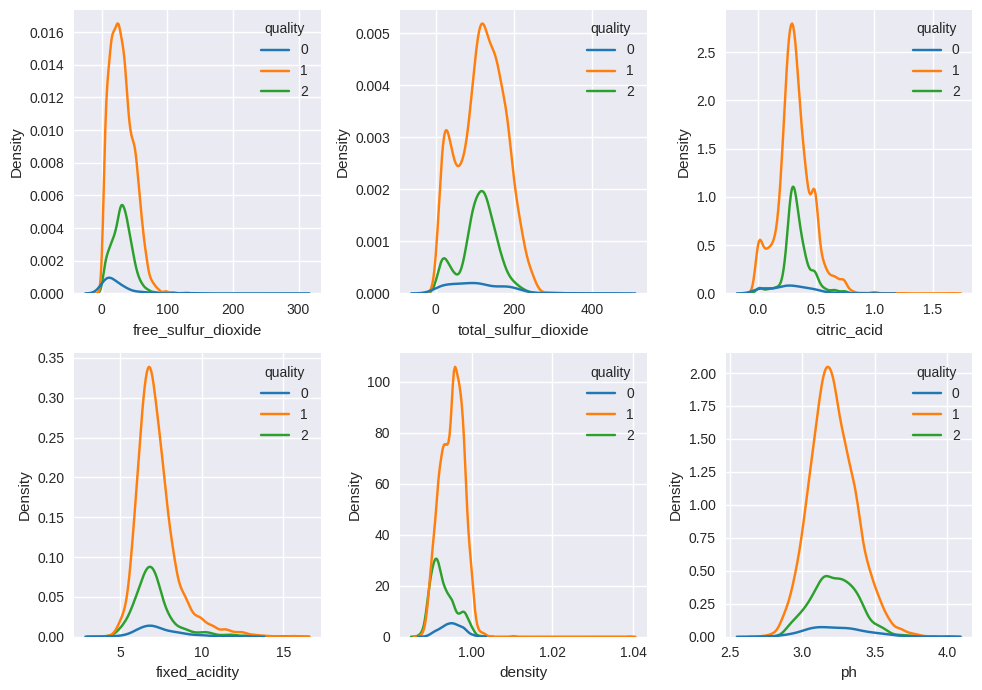

In [33]:
foo = ['free_sulfur_dioxide','total_sulfur_dioxide','citric_acid','fixed_acidity','density','ph']

fig,axes  = plt.subplots(ncols=3,nrows=2,figsize=(10,7))
ax = axes.flatten()
for i,f in enumerate(foo):
    sns.kdeplot(x=f,hue='quality',palette='tab10',common_norm=True,data=df,ax=ax[i])

fig.tight_layout()


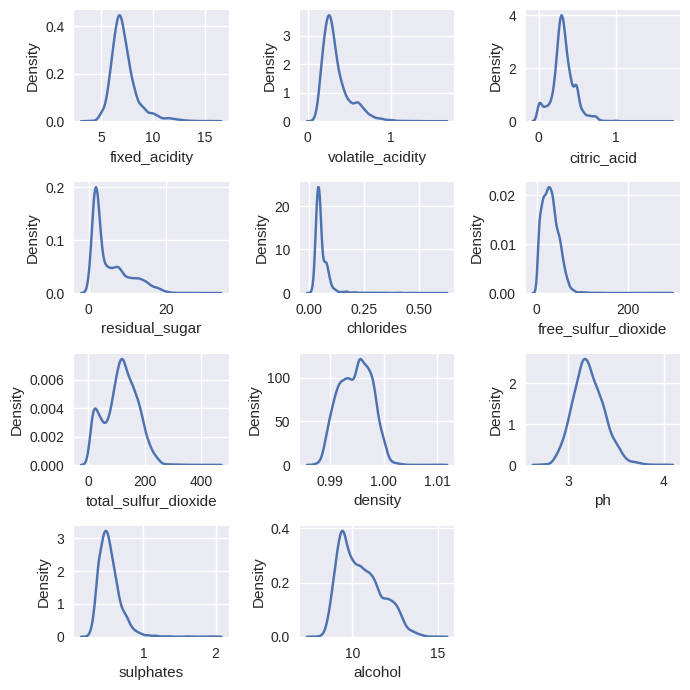

In [34]:
fig,ax = plt.subplots(ncols=3,nrows=4,figsize=(7,7))
axes = ax.flatten()

for i,feat in enumerate(features[1:]):
    sns.kdeplot(df_full_train,x=feat,ax=axes[i])

axes[-1].remove()

fig.tight_layout()

In the figure above we see that some of the features count with skewed distributions. Should we use any scaling/normalizing transformation?

### Feature Importance

In [35]:
from sklearn.ensemble import RandomForestClassifier

In [36]:
X_full_train = df_full_train[features].values.reshape(-1,len(features))
y_full_train = df_full_train.quality.values
X_full_train.shape,y_full_train.shape

((5197, 12), (5197,))

In [37]:
from sklearn.feature_extraction import DictVectorizer 

In [38]:
dv = DictVectorizer(sparse=False)
full_train_dicts = df_full_train[features].to_dict(orient='records')

X_full_train = dv.fit_transform(full_train_dicts)

In [39]:
rf = RandomForestClassifier(random_state=1)
rf.fit(X_full_train,y_full_train)
importances = pd.Series(rf.feature_importances_.round(4),index=dv.get_feature_names_out())
importances.sort_values(ascending=False)

alcohol                 0.1389
density                 0.1108
volatile_acidity        0.0943
total_sulfur_dioxide    0.0874
chlorides               0.0871
sulphates               0.0843
residual_sugar          0.0830
free_sulfur_dioxide     0.0815
ph                      0.0813
citric_acid             0.0756
fixed_acidity           0.0721
type                    0.0038
dtype: float64

<AxesSubplot: >

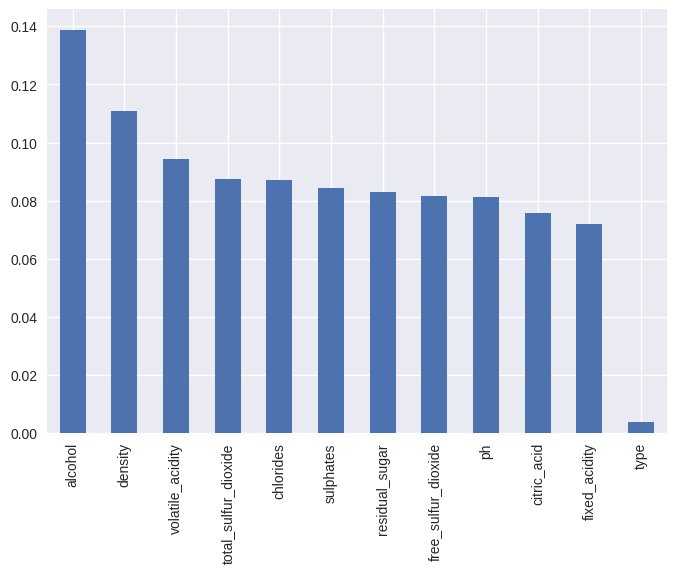

In [40]:
importances.sort_values(ascending=False).plot(kind="bar")

# Modeling

In [41]:
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb 

from sklearn.preprocessing import RobustScaler,label_binarize


# Metrics 
from sklearn.metrics import roc_curve,roc_auc_score, confusion_matrix,accuracy_score,classification_report
# feature_extraction
from sklearn.feature_extraction import DictVectorizer 

# Tunning 
from sklearn.model_selection import GridSearchCV 

# Pipeline
from sklearn.pipeline import Pipeline

from utils import train_evaluate_model


## Make a Baseline model 

### Without Scaling

In [42]:
classes = [0,1,2]

train_dicts = df_train[features].to_dict(orient='records')
val_dicts = df_val[features].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)


params = {
    'train':(X_train,y_train),
    'val':(X_val,y_val),
    'classes':classes
}

metrics = ['auc','f1_macro','f1_weighted']
models = {}

Weighted ACU 0.664
Macro avg F1-score 0.4
Weighted avg F1-score 0.52


/Data/Daniel/Projects/mlzoomcamp-2022-01-trusting-varahamihira/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Text(70.72222222222221, 0.5, 'Actual')

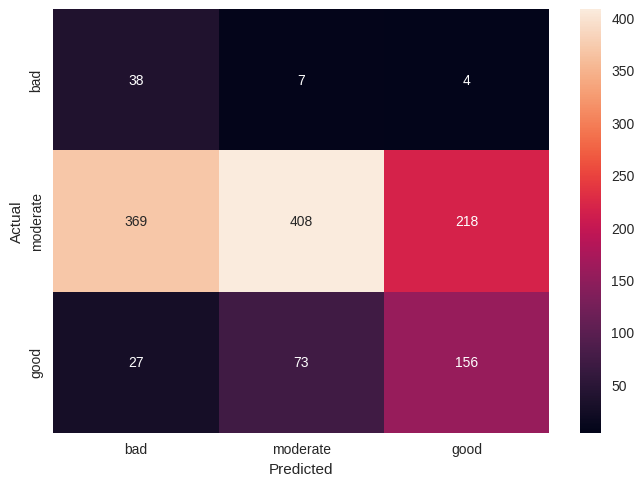

In [45]:
steps = [
    ('classifier',LogisticRegression(multi_class='multinomial',class_weight='balanced'))
]
pipeline = Pipeline(steps=steps)

pipeline,score,conf_matrix,clf_rep = train_evaluate_model(pipeline,**params) 
models['LR_base'] = score

print(f"Weighted ACU {score['auc']}")
print(f"Macro avg F1-score {score['f1_macro']}")
print(f"Weighted avg F1-score {score['f1_weighted']}")


fig,ax = plt.subplots()
sns.heatmap(conf_matrix,annot=True,xticklabels=['bad','moderate','good'],yticklabels=['bad','moderate','good'],fmt='.0f',ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')


We see that the model struggle to converge. Lets apply a scaling to the features, `RobustScaler`

Weighted ACU 0.727
Macro avg F1-score 0.46
Weighted avg F1-score 0.61


Text(70.72222222222221, 0.5, 'Actual')

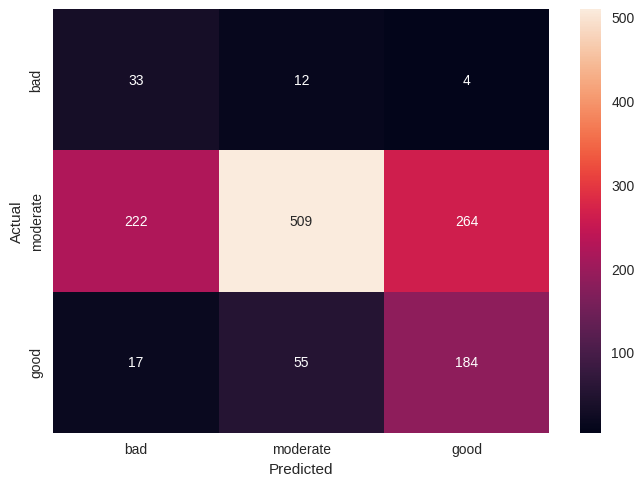

In [46]:
steps = [
    ('preprocessing',RobustScaler()),
    ('classifier',LogisticRegression(multi_class='multinomial',class_weight='balanced'))
]
pipeline = Pipeline(steps=steps)

pipeline,score,conf_matrix,clf_rep = train_evaluate_model(pipeline,**params)
models['LR_scaled'] = score
print(f"Weighted ACU {score['auc']}")
print(f"Macro avg F1-score {score['f1_macro']}")
print(f"Weighted avg F1-score {score['f1_weighted']}")

fig,ax = plt.subplots()
sns.heatmap(conf_matrix,annot=True,xticklabels=['bad','moderate','good'],yticklabels=['bad','moderate','good'],fmt='.0f',ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')


### Lets Look at parameter C

<AxesSubplot: >

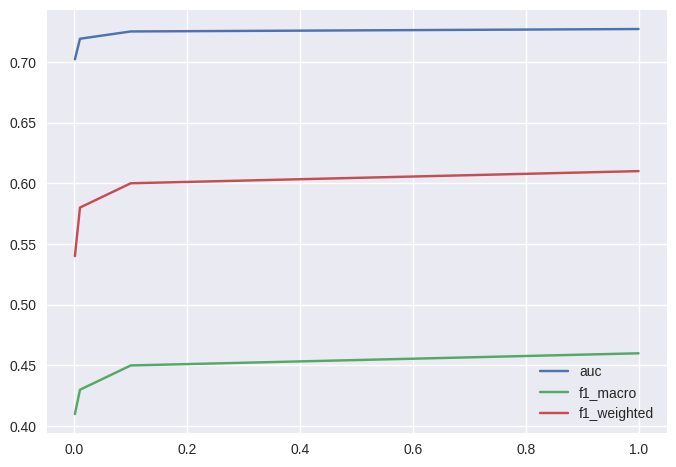

In [47]:
Cs = [0.001,0.01,0.1,1]

scores = []
for c in Cs:
    steps = [
        ('preprocessing',RobustScaler()),
        ('classifier',LogisticRegression(C=c,
                     multi_class='multinomial',
                     class_weight='balanced')
                     )
    ]
    pipeline = Pipeline(steps=steps) 
    pipeline,score,conf_matrix,clf_rep = train_evaluate_model(pipeline,**params) 
    scores.append(score)

scores_df = pd.DataFrame(scores,index=Cs)
scores_df.plot()

Weighted ACU 0.727
Macro avg F1-score 0.46
Weighted avg F1-score 0.61


Text(70.72222222222221, 0.5, 'Actual')

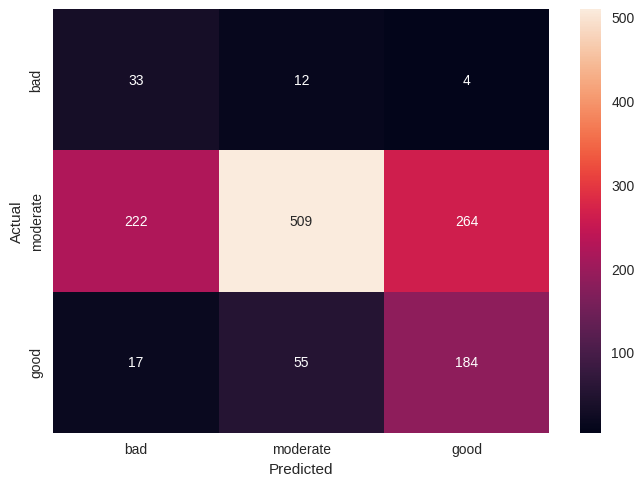

In [48]:
steps = [
    ('preprocessing',RobustScaler()),
    ('classifier',LogisticRegression(C=1,multi_class='multinomial',class_weight='balanced'))
]
pipeline = Pipeline(steps=steps)

pipeline,score,conf_matrix,clf_rep = train_evaluate_model(pipeline,**params)
models['LR_scaled'] = score

print(f"Weighted ACU {score['auc']}")
print(f"Macro avg F1-score {score['f1_macro']}")
print(f"Weighted avg F1-score {score['f1_weighted']}") 

fig,ax = plt.subplots()
sns.heatmap(conf_matrix,annot=True,xticklabels=['bad','moderate','good'],yticklabels=['bad','moderate','good'],fmt='.0f',ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

## Decision Tree

Weighted ACU 0.716
Macro avg F1-score 0.52
Weighted avg F1-score 0.72


Text(70.72222222222221, 0.5, 'Actual')

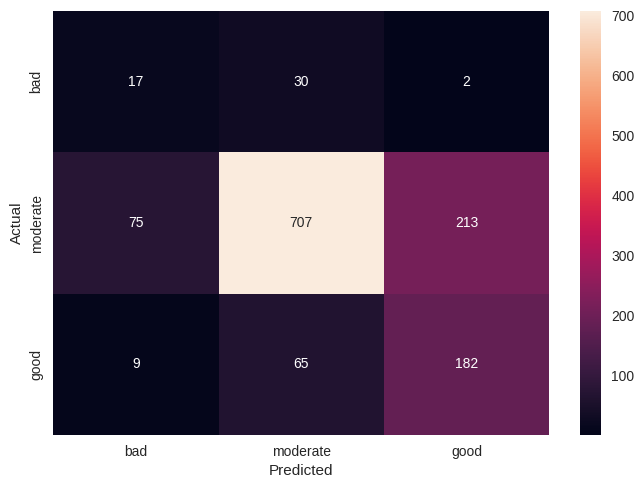

In [49]:
steps = [
    ('preprocessing',RobustScaler()),
    ('classifier',DecisionTreeClassifier(
                 max_depth=10,
                 class_weight='balanced',
                 random_state=1))
]
pipeline = Pipeline(steps=steps)
pipeline,score,conf_matrix,clf_rep = train_evaluate_model(pipeline,**params)
models['DT_base'] = score

print(f"Weighted ACU {score['auc']}")
print(f"Macro avg F1-score {score['f1_macro']}")
print(f"Weighted avg F1-score {score['f1_weighted']}")

fig,ax = plt.subplots()
sns.heatmap(conf_matrix,annot=True,xticklabels=['bad','moderate','good'],yticklabels=['bad','moderate','good'],fmt='.0f',ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

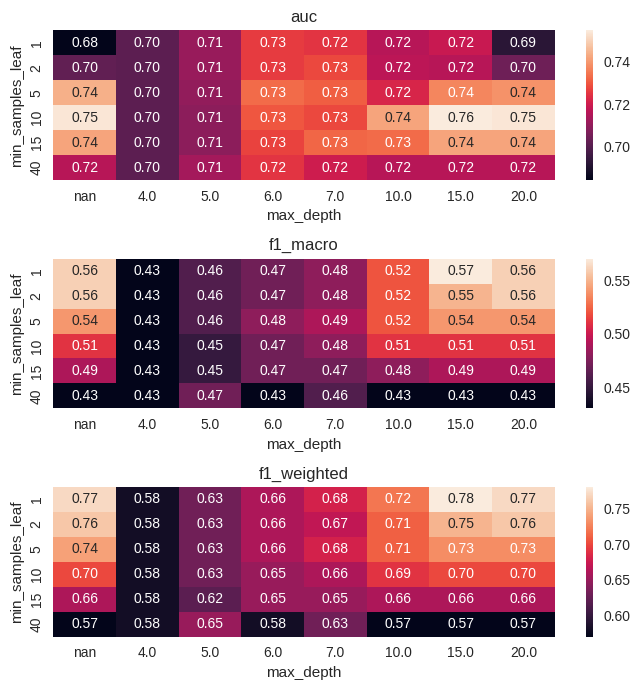

In [50]:
scores = []
for d in [4,5,6,7,10,15,20,None]:
    for s in [1,2,5,10,15,40]: # min_sample_leaf
        steps = [
        ('preprocessing',RobustScaler()),
        ('classifier',DecisionTreeClassifier(
                    max_depth=d,
                    min_samples_leaf=s,
                    class_weight='balanced',
                    random_state=1))
    ]
        pipeline = Pipeline(steps=steps)
        pipeline,score,conf_matrix,clf_rep = train_evaluate_model(pipeline,**params)
        score.update({'max_depth':d,'min_samples_leaf':s})
        scores.append(score)
scores_df = pd.DataFrame(scores)
scores_pivot = scores_df.pivot(index='min_samples_leaf',columns='max_depth',values=metrics).round(3)

fig,ax = plt.subplots(nrows=3,figsize=(7,7))
for i,k in enumerate(metrics):
    sns.heatmap(scores_pivot[k],annot=True,fmt='.2f',ax=ax[i])
    ax[i].set_title(k)

fig.tight_layout()

In [51]:
scores_df.sort_values(by=metrics,ascending=False).head()

,auc,f1_macro,f1_weighted,max_depth,min_samples_leaf
33,0.755,0.51,0.70,15.0,10
39,0.754,0.51,0.70,20.0,10
45,0.754,0.51,0.70,NaN,10
44,0.744,0.54,0.74,NaN,5
27,0.742,0.51,0.69,10.0,10


In [52]:
scores_df.sort_values(by=['f1_weighted'],ascending=False).head()

,auc,f1_macro,f1_weighted,max_depth,min_samples_leaf
30,0.719,0.57,0.78,15.0,1
36,0.692,0.56,0.77,20.0,1
42,0.684,0.56,0.77,NaN,1
43,0.702,0.56,0.76,NaN,2
37,0.704,0.56,0.76,20.0,2


### Best DT

Weighted ACU 0.719
Macro avg F1-score 0.57
Weighted avg F1-score 0.78


Text(70.72222222222221, 0.5, 'Actual')

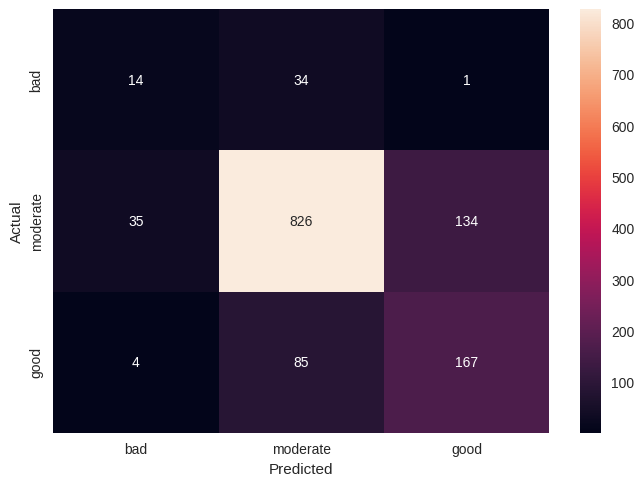

In [54]:
max_depth = 15
min_samples_leaf = 1
steps = [
    ('preprocessing',RobustScaler()),
    ('classifier',DecisionTreeClassifier(
                 max_depth=max_depth,
                 min_samples_leaf=min_samples_leaf,
                 class_weight='balanced',
                 random_state=1))
]
pipeline = Pipeline(steps=steps)
pipeline,score,conf_matrix,clf_rep = train_evaluate_model(pipeline,**params)
models['DT_best_f1_weighted'] = score

print(f"Weighted ACU {score['auc']}")
print(f"Macro avg F1-score {score['f1_macro']}")
print(f"Weighted avg F1-score {score['f1_weighted']}")

fig,ax = plt.subplots()
sns.heatmap(conf_matrix,annot=True,xticklabels=['bad','moderate','good'],yticklabels=['bad','moderate','good'],fmt='.0f',ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

In [55]:
clf_rep.loc['recall'].round(2)

bad             0.29
moderate        0.83
good            0.65
accuracy        0.77
macro avg       0.59
weighted avg    0.77
Name: recall, dtype: float64

From the confusion matrix, we see that this model is able to predict 
correctly:
- ~29% of the bad-quality wines
- ~83% moderate-quality wines
- ~65% Good-quality wines

Weighted ACU 0.755
Macro avg F1-score 0.51
Weighted avg F1-score 0.7


Text(70.72222222222221, 0.5, 'Actual')

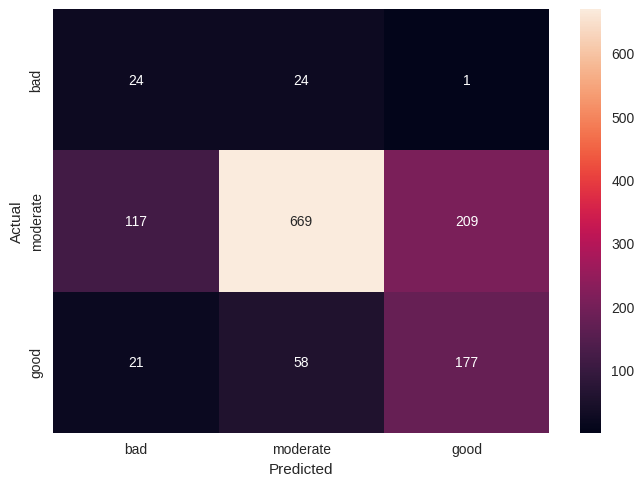

In [58]:
max_depth = 15
min_samples_leaf = 10
steps = [
    ('preprocessing',RobustScaler()),
    ('classifier',DecisionTreeClassifier(
                 max_depth=max_depth,
                 min_samples_leaf=min_samples_leaf,
                 class_weight='balanced',
                 random_state=1))
]
pipeline = Pipeline(steps=steps)
pipeline,score,conf_matrix,clf_rep = train_evaluate_model(pipeline,**params)
models['DT_best'] = score

print(f"Weighted ACU {score['auc']}")
print(f"Macro avg F1-score {score['f1_macro']}")
print(f"Weighted avg F1-score {score['f1_weighted']}")


fig,ax = plt.subplots()
sns.heatmap(conf_matrix,annot=True,xticklabels=['bad','moderate','good'],yticklabels=['bad','moderate','good'],fmt='.0f',ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

In [59]:
clf_rep.loc['recall'].round(2)

bad             0.49
moderate        0.67
good            0.69
accuracy        0.67
macro avg       0.62
weighted avg    0.67
Name: recall, dtype: float64

From the confusion matrix, we see that this model is able to predict 
correctly:
- ~49% of the bad-quality wines
- ~67% moderate-quality wines
- ~ 69% Good-quality wines

## Random Forests

Weighted ACU 0.86
Macro avg F1-score 0.59
Weighted avg F1-score 0.82


Text(70.72222222222221, 0.5, 'Actual')

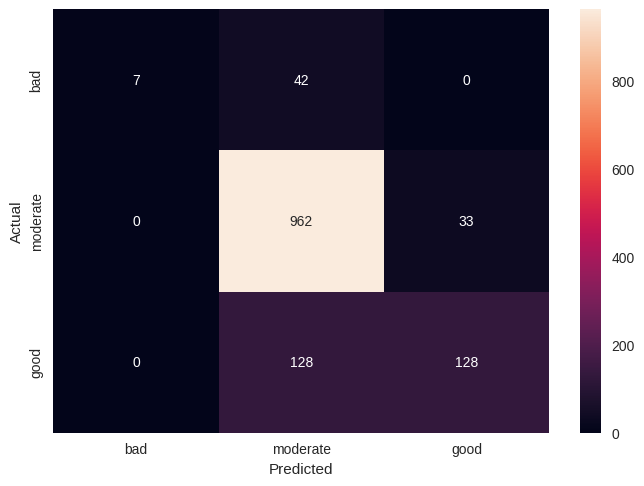

In [60]:
steps = [
    ('preprocessing',RobustScaler()),
    ('classifier',RandomForestClassifier(
                n_estimators=100,
                class_weight='balanced',
                random_state=1))
]
pipeline = Pipeline(steps=steps)
pipeline,score,conf_matrix,clf_rep = train_evaluate_model(pipeline,**params)
models['RT_base'] = score

print(f"Weighted ACU {score['auc']}")
print(f"Macro avg F1-score {score['f1_macro']}")
print(f"Weighted avg F1-score {score['f1_weighted']}")


fig,ax = plt.subplots()
sns.heatmap(conf_matrix,annot=True,xticklabels=['bad','moderate','good'],yticklabels=['bad','moderate','good'],fmt='.0f',ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

In [61]:
clf_rep.loc['recall'].round(2)

bad             0.14
moderate        0.97
good            0.50
accuracy        0.84
macro avg       0.54
weighted avg    0.84
Name: recall, dtype: float64

From the confusion matrix, we see that this model is able to predict 
correctly:
- ~14% of the bad-quality wines
- ~97% moderate-quality wines
- ~ 50% Good-quality wines

Lets Look at the effect of `n_estimators` and `max_depth`

      auc  f1_macro  f1_weighted  max_depth  n_estimators
12  0.865      0.58         0.82         20            50
14  0.864      0.58         0.82         20           300
13  0.863      0.58         0.82         20           100
9   0.859      0.58         0.82         15           300
8   0.854      0.59         0.82         15           100


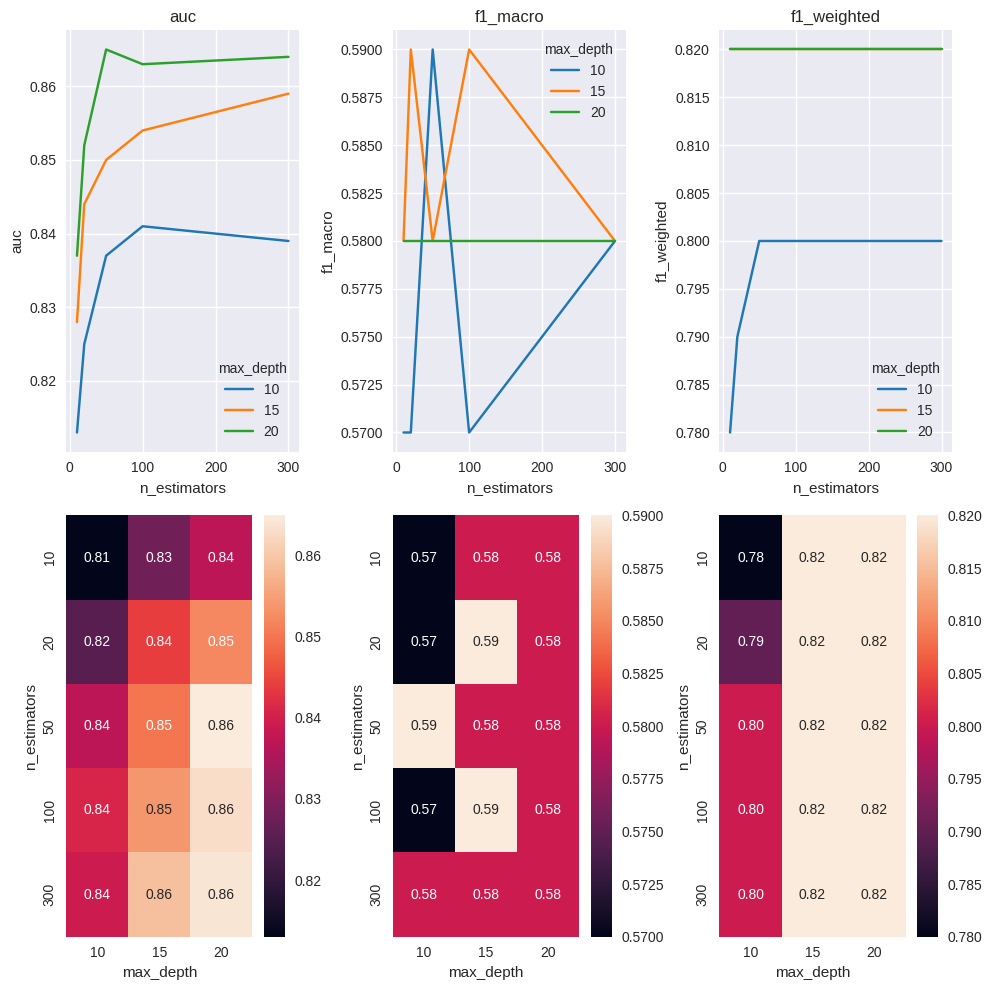

In [62]:
scores = []
for d in [10,15,20]:
    for n in [10,20,50,100,300]: 
        steps = [
        ('preprocessing',RobustScaler()),
        ('classifier',RandomForestClassifier(
            n_estimators=n,
            max_depth=d,
            class_weight='balanced',
            random_state=1))
            ]
        pipeline = Pipeline(steps=steps)
        pipeline,score,conf_matrix,clf_rep = train_evaluate_model(pipeline,**params) 
        score.update({'max_depth':d,'n_estimators':n})
        scores.append(score)

scores_df = pd.DataFrame(scores)
print(scores_df.sort_values(by='auc',ascending=False).head(5))
scores_pivot = scores_df.pivot(index='n_estimators',columns='max_depth',values=metrics).round(3)

fig,ax = plt.subplots(ncols=3,nrows=2,figsize=(10,10))

for i,k in enumerate(metrics):
    sns.lineplot(x='n_estimators',y=k,hue='max_depth',palette='tab10',data=scores_df,ax=ax[0,i])
    sns.heatmap(scores_pivot[k],annot=True,fmt='.2f',ax=ax[1,i])

    ax[0,i].set_title(k)
fig.tight_layout()


What about changing the `min_samples_leaf`? Lets keep `max_depth` as 15, given the step above.

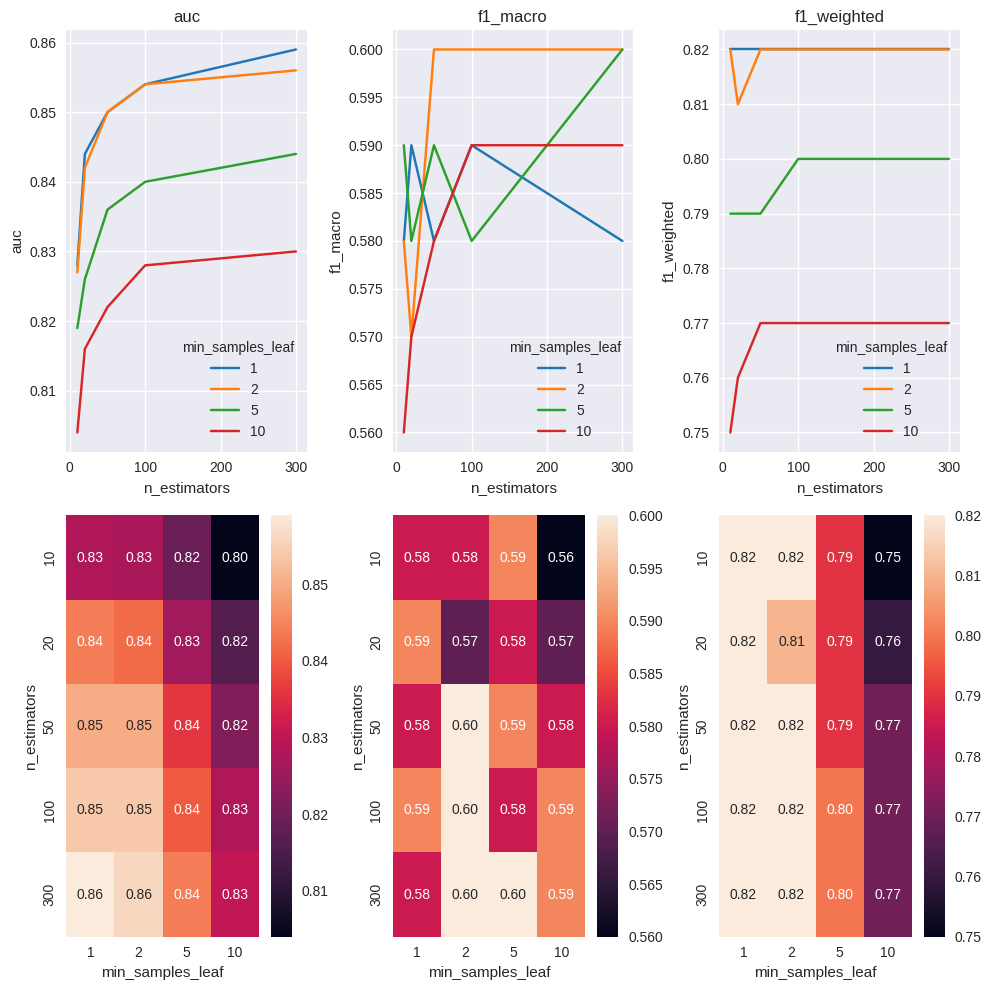

In [63]:
max_depth = 15
scores = []
for mleaf in [1,2,5,10]:
    for n in [10,20,50,100,300]: # min_sample_leaf
        steps = [
        ('preprocessing',RobustScaler()),
        ('classifier',RandomForestClassifier(
                n_estimators=n,
                max_depth=max_depth,
                min_samples_leaf=mleaf,
                class_weight='balanced',
                random_state=1))
    ]
        pipeline = Pipeline(steps=steps)
        pipeline,score,conf_matrix,clf_rep = train_evaluate_model(pipeline,**params)
        score.update({'min_samples_leaf':mleaf,'n_estimators':n})
        scores.append(score)
scores_df = pd.DataFrame(scores)

scores_pivot = scores_df.pivot(index='n_estimators',columns='min_samples_leaf',values=metrics).round(3)

fig,ax = plt.subplots(ncols=3,nrows=2,figsize=(10,10))

for i,k in enumerate(metrics):
    sns.lineplot(x='n_estimators',y=k,hue='min_samples_leaf',palette='tab10',data=scores_df,ax=ax[0,i])
    sns.heatmap(scores_pivot[k],annot=True,fmt='.2f',ax=ax[1,i])

    ax[0,i].set_title(k)
fig.tight_layout()


Weighted ACU 0.854
Macro avg F1-score 0.6
Weighted avg F1-score 0.82


Text(70.72222222222221, 0.5, 'Actual')

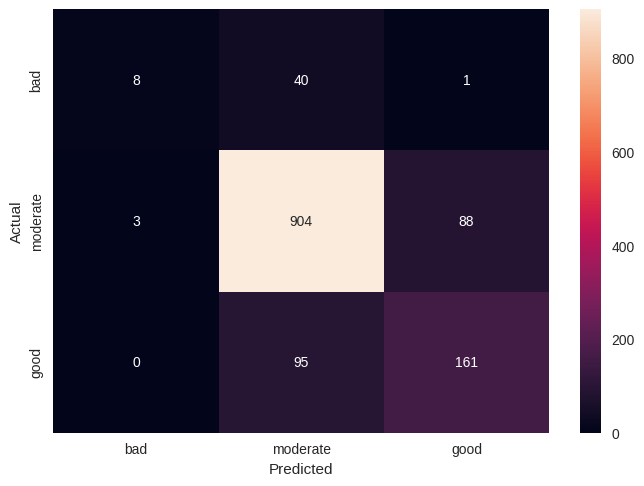

In [64]:
best_params = {
    "min_samples_leaf":2,
    "max_depth": 15,
    "n_estimators": 100,
}

steps = [
    ('preprocessing',RobustScaler()),
    ('classifier',RandomForestClassifier(
                **best_params,
                class_weight='balanced',
                random_state=1))
]
pipeline = Pipeline(steps=steps)
pipeline,score,conf_matrix,clf_rep = train_evaluate_model(pipeline,**params)
models['RT_best'] = score

print(f"Weighted ACU {score['auc']}")
print(f"Macro avg F1-score {score['f1_macro']}")
print(f"Weighted avg F1-score {score['f1_weighted']}")

fig,ax = plt.subplots()
sns.heatmap(conf_matrix,annot=True,xticklabels=['bad','moderate','good'],yticklabels=['bad','moderate','good'],fmt='.0f',ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

In [65]:
clf_rep.loc['recall'].round(2)

bad             0.16
moderate        0.91
good            0.63
accuracy        0.83
macro avg       0.57
weighted avg    0.83
Name: recall, dtype: float64

From the confusion matrix, we see that this model is able to predict 
correctly:
- ~16% of the bad-quality wines
- ~91% moderate-quality wines
- ~63% Good-quality wines

## XGBOOST

Weighted ACU 0.843
Macro avg F1-score 0.58
Weighted avg F1-score 0.81


Text(70.72222222222221, 0.5, 'Actual')

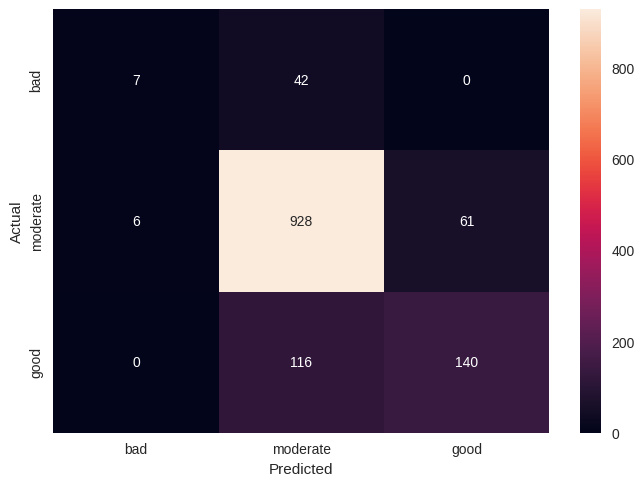

In [67]:
xgb_params = {
    "learning_rate":0.1, #Learning rate
    "max_depth":15,
    "min_child_weight": 1,
    'n_estimators':50,
    "objective":"multi:softprob",
    'nthread':8,
    'eval_metric':['auc','mlogloss'],
    'num_class':3,
    'seed': 1,
    'verbosity':0,
}

steps = [
    ('preprocessing',RobustScaler()),
    ('classifier',xgb.XGBClassifier(**xgb_params))
]
pipeline = Pipeline(steps=steps)
pipeline,score,conf_matrix,clf_rep = train_evaluate_model(pipeline,**params)
models['xgb_base'] = score 

print(f"Weighted ACU {score['auc']}")
print(f"Macro avg F1-score {score['f1_macro']}")
print(f"Weighted avg F1-score {score['f1_weighted']}")

fig,ax = plt.subplots()
sns.heatmap(conf_matrix,annot=True,xticklabels=['bad','moderate','good'],yticklabels=['bad','moderate','good'],fmt='.0f',ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')


In [69]:
clf_rep.loc['recall'].round(2)

bad             0.14
moderate        0.93
good            0.55
accuracy        0.83
macro avg       0.54
weighted avg    0.83
Name: recall, dtype: float64

From the confusion matrix, we see that this model is able to predict 
correctly:
- ~14% of the bad-quality wines
- ~93% moderate-quality wines
- ~55% Good-quality wines

In [70]:
scores = [] 
for lr in [0.01,0.1,1]:
    for n in [100,150,200,300]:
        xgb_params = {
            "learning_rate":lr, #Learning rate
            "max_depth":15,
            "min_child_weight": 1,
            'n_estimators':n,
            "objective":"multi:softprob",
            'nthread':8,
            'eval_metric':['auc','mlogloss'],
            'num_class':3,
            'seed': 1,
            'verbosity':0,
        }

        steps = [
            ('preprocessing',RobustScaler()),
            ('classifier',xgb.XGBClassifier(**xgb_params))
        ]
        pipeline = Pipeline(steps=steps)
        pipeline,score,conf_matrix,clf_rep = train_evaluate_model(pipeline,**params)
        score.update({'learning_rate':lr,'n_estimators':n})
        scores.append(score)

scores_df = pd.DataFrame(scores)
scores_df.sort_values(by=metrics,ascending=False).head(5)


,auc,f1_macro,f1_weighted,learning_rate,n_estimators
5,0.854,0.60,0.82,0.1,150
6,0.854,0.59,0.82,0.1,200
4,0.853,0.60,0.82,0.1,100
7,0.852,0.60,0.82,0.1,300
9,0.844,0.59,0.82,1.0,150


## Best XGboost

Weighted ACU 0.854
Macro avg F1-score 0.6
Weighted avg F1-score 0.82


Text(70.72222222222221, 0.5, 'Actual')

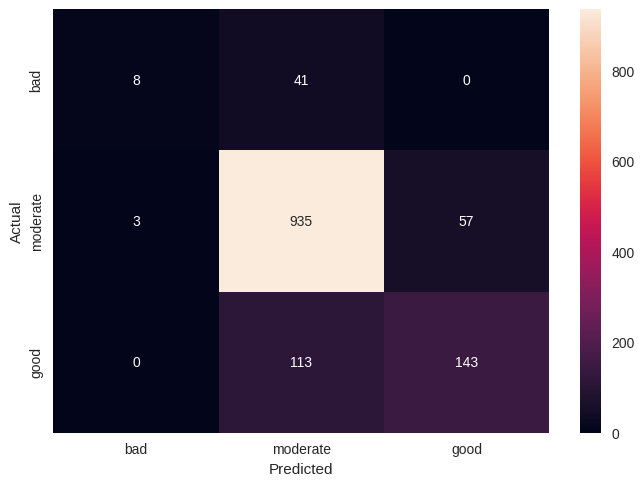

In [75]:
best_xgb_params = {
    "learning_rate":0.1, #Learning rate
    "max_depth":15,
    "min_child_weight": 1,
    'n_estimators':150,
    "objective":"multi:softprob",
    'nthread':8,
    'eval_metric':['auc','mlogloss'],
    'num_class':3,
    'seed': 1,
    'verbosity':0,
}

steps = [
    ('preprocessing',RobustScaler()),
    ('classifier',xgb.XGBClassifier(**best_xgb_params))
]
pipeline = Pipeline(steps=steps)
pipeline,score,conf_matrix,clf_rep = train_evaluate_model(pipeline,**params)
models['xgb_best'] = score 

print(f"Weighted ACU {score['auc']}")
print(f"Macro avg F1-score {score['f1_macro']}")
print(f"Weighted avg F1-score {score['f1_weighted']}")

fig,ax = plt.subplots()
sns.heatmap(conf_matrix,annot=True,xticklabels=['bad','moderate','good'],yticklabels=['bad','moderate','good'],fmt='.0f',ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

In [76]:
clf_rep.loc['recall'].round(2)

bad             0.16
moderate        0.94
good            0.56
accuracy        0.84
macro avg       0.55
weighted avg    0.84
Name: recall, dtype: float64

From the confusion matrix, we see that this model is able to predict 
correctly:
- ~16% of the bad-quality wines
- ~94% moderate-quality wines
- ~56% Good-quality wines

In [209]:
mods = pd.DataFrame().from_dict(models,orient='index')
mods.sort_values(by=['f1_macro','f1_weighted'],ascending=False).head(5)

,auc,f1_macro,f1_weighted
RT_best,0.854,0.60,0.82
xgb_best,0.854,0.60,0.82
RT_base,0.860,0.59,0.82
xgb_base,0.843,0.58,0.81
DT_best_f1_weighted,0.719,0.57,0.78


# Select Best Model 

Recall for the best models are as follows: 
                         
| Model    	| Bad 	| Moderate 	| Good 	|
|----------	|-----	|----------	|------	|
| RT_best  	| 16  	| 91       	| 63   	|
| xgb_best 	| 16  	| 94       	| 56   	|
| RT_base  	| 14  	| 97       	| 50   	|
| xgb_base 	| 14  	| 93       	| 55   	|

We can see that while the metrics are quite similar, some models perform better or worst in some of the categories. In general, we get good predictions for moderate-quality wines. However, Some models are better at predicting either the bad- or good-quality wines. 

If we compare the best RandomForest (RT_best) with the best XGB (xgb_best), we can observe that both models have the same low recall for bad-quality wines. RT_best perform better at predicting good-quality while xgb_best is better at predicting moderate quality wines. 

If we assume that we care more about prediciting correctly the good quality wine, then we select as the best model `RT_best`

Lets take the full training dataset now: 

In [77]:
df_full_train = df_full_train.reset_index(drop=True)

y_full_train = df_full_train.quality.values

del df_full_train['quality']

In [80]:
classes = [0,1,2]

train_full_dicts = df_full_train[features].to_dict(orient='records')
test_dicts = df_test[features].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(train_full_dicts)
X_test = dv.transform(test_dicts)

params = {
    'train':(X_full_train,y_full_train),
    'val':(X_test,y_test),
    'classes':classes
}

metrics = ['auc','f1_macro','f1_weighted']
models = {}

Weighted ACU 0.857
Macro avg F1-score 0.58
Weighted avg F1-score 0.82


Text(70.72222222222221, 0.5, 'Actual')

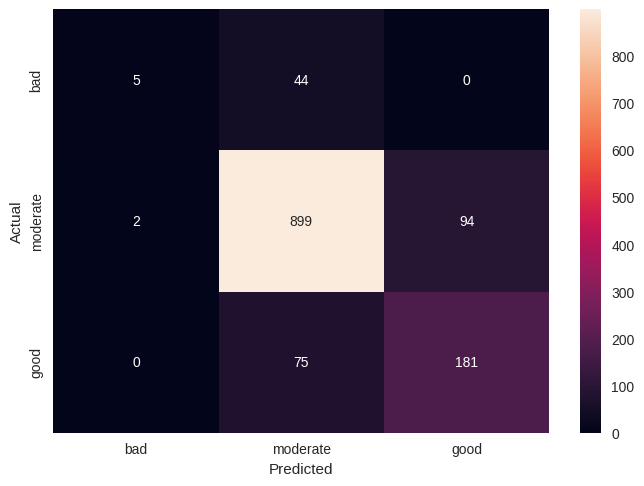

In [81]:
best_params = {
    "min_samples_leaf":2,
    "max_depth": 15,
    "n_estimators": 100,
}

steps = [
    ('preprocessing',RobustScaler()),
    ('classifier',RandomForestClassifier(
                **best_params,
                class_weight='balanced',
                random_state=1))
]
pipeline = Pipeline(steps=steps)
pipeline,score,conf_matrix,clf_rep = train_evaluate_model(pipeline,**params)

print(f"Weighted ACU {score['auc']}")
print(f"Macro avg F1-score {score['f1_macro']}")
print(f"Weighted avg F1-score {score['f1_weighted']}")

fig,ax = plt.subplots()
sns.heatmap(conf_matrix,annot=True,xticklabels=['bad','moderate','good'],yticklabels=['bad','moderate','good'],fmt='.0f',ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

In [91]:
clf_rep.T

,precision,recall,f1-score,support
bad,0.714286,0.102041,0.178571,49.000000
moderate,0.883104,0.903518,0.893194,995.000000
good,0.658182,0.707031,0.681733,256.000000
accuracy,0.834615,0.834615,0.834615,0.834615
macro avg,0.751857,0.570863,0.584499,1300.000000
weighted avg,0.832449,0.834615,0.824617,1300.000000


In [89]:
clf_rep.loc['recall'].round(3)

bad             0.102
moderate        0.904
good            0.707
accuracy        0.835
macro avg       0.571
weighted avg    0.835
Name: recall, dtype: float64

In [93]:
rs = pipeline.steps[0][1]

<AxesSubplot: ylabel='Frequency'>

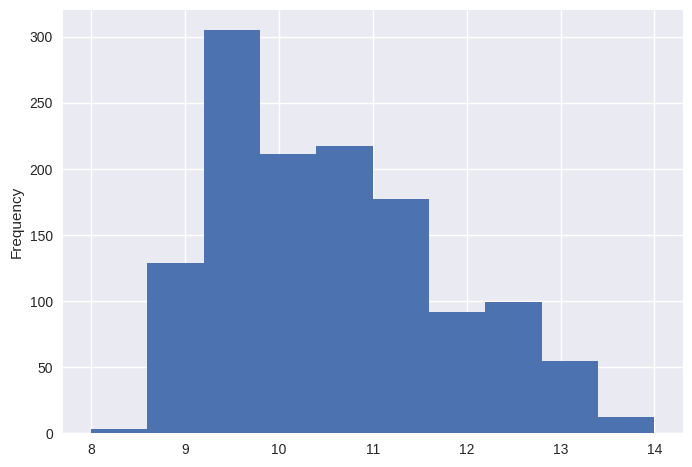

In [105]:
df_test.alcohol.plot.hist(bins=10)

In [87]:
pipeline.steps[1][1].predict(X_test)

array([1, 1, 1, ..., 1, 1, 1])